In [1]:
import pandas as pd
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz

In [2]:
df = pd.read_csv('Data/Wine/Wine_red.csv', sep=';')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [3]:
#bin quality
df['rating'] = pd.qcut(df.quality , q=2, labels = ['bad','good'])
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,rating
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad


In [4]:
df.rating.value_counts()

bad     1382
good     217
Name: rating, dtype: int64

In [5]:
#split into attributes and target
attributes = df.drop(['quality','rating'], axis = 1)
target = df.rating

In [6]:
# Initialize the tree
Tree = tree.DecisionTreeClassifier(max_depth = 3)

In [7]:
#fit tree
Tree.fit(attributes,target)

DecisionTreeClassifier(max_depth=3)

In [8]:
df['predict'] = Tree.predict(attributes)
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,rating,predict
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad,bad


In [9]:
num_errors = (df.rating != df.predict).sum()
error_rate = num_errors/df.shape[0]
error_rate.round(2)
#not goot because big tree, too small error rate

0.11

In [10]:
df.rating.value_counts()
# predict the most frequent class

bad     1382
good     217
Name: rating, dtype: int64

In [11]:
#baseline: just predict everything bad -> only make 217 mistakes -> 14 percent error rate -> seems reasonable
error_rate_baseline = 217/(1382+217)
round(error_rate_baseline,2)

0.14

### Training Error

In [12]:
#baseline: 0 depth tree
tree_depth = []
error_rate = []
num_records = df.shape[0]
for depth in range(1, 11): #depth has to start at 1, cannot be 0
    Tree = tree.DecisionTreeClassifier(max_depth = depth)
    Tree.fit(attributes,target)
    df['predict'] = Tree.predict(attributes)
    num_errors = (df.rating != df.predict).sum()
    tree_depth.append(depth)
    error_rate.append(num_errors/num_records)
    
    
results = pd.DataFrame()
results['depth'] = tree_depth
results['error(training)'] = error_rate
results['error(baseline)'] = 217/num_records
results.round(2)

,depth,error(training),error(baseline)
0,1,0.14,0.14
1,2,0.11,0.14
2,3,0.11,0.14
3,4,0.09,0.14
4,5,0.07,0.14
5,6,0.05,0.14
6,7,0.04,0.14
7,8,0.03,0.14
8,9,0.02,0.14
9,10,0.02,0.14


Text(0, 0.5, 'error rate')

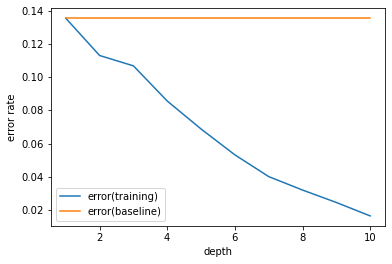

In [13]:
results.plot.line(x = 'depth' , y=['error(training)', 'error(baseline)'])
plt.ylabel('error rate')
#perfect fit -> tree depth to 10

### Validation Error

In [14]:
df = df.drop('predict',axis=1)
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,rating
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad


In [15]:
#split data into training and validation data sets
df_valid = df.sample(frac = 0.2, random_state=1)
df_train = df.drop(df_valid.index)

In [16]:
attributes_train = df_train.drop(['quality','rating'], axis = 1)
attributes_valid = df_valid.drop(['quality','rating'], axis = 1)
target_train = df_train.rating
target_valid = df_valid.rating

In [17]:
#validation set -> set never seen before
tree_depth = []
error_train = []
error_valid = []
num_train = df_train.shape[0]
num_valid = df_valid.shape[0]
for depth in range(1, 11): #depth has to start at 1, cannot be 0
    Tree = tree.DecisionTreeClassifier(max_depth = depth)
    Tree.fit(attributes_train,target_train)
    df_train['predict'] = Tree.predict(attributes_train)
    df_valid['predict'] = Tree.predict(attributes_valid) #data never seen befor
    err_train = (df_train.rating != df_train.predict).sum()
    err_valid = (df_valid.rating != df_valid.predict).sum()
    tree_depth.append(depth)
    error_train.append(err_train/num_train)
    error_valid.append(err_valid/num_valid)
    
    
results = pd.DataFrame()
results['depth'] = tree_depth
results['error(train)'] = error_train
results['error(valid)'] = error_valid
results.round(5)
# depth 3 tree with 10 percent error and a depth 8 tree with 10 percent error
#-> choose the simpler tree -> goal is understaing data -> more complicated more confusing

#fit -> specific data in training set -> do not fit -> need general

,depth,error(train),error(valid)
0,1,0.14464,0.10000
1,2,0.11415,0.10938
2,3,0.11102,0.10000
3,4,0.08757,0.11875
4,5,0.06333,0.11562
5,6,0.05082,0.10938
6,7,0.03675,0.10625
7,8,0.02893,0.09375
8,9,0.02111,0.10625
9,10,0.01720,0.10312


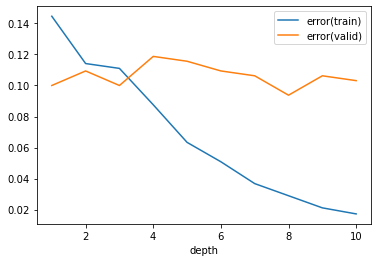

In [18]:
results.plot.line(x = 'depth' , y=['error(train)', 'error(valid)'])
#plt.ylabel('error rate')